# Homework 2: Fine-tuning & Prompting of LMs (51 points)

The focus of this homework is on one prominent fine-tuning technique -- reinforcement learning from human feedback -- and on critically thinking about prompting techniques and papers about language models

### Logistics

* submission deadline: June 3rd th 23:59 German time via Moodle
  * please upload a **SINGLE .IPYNB FILE named Surname_FirstName_HW2.ipynb** containing your solutions of the homework.
* please solve and submit the homework **individually**!
* if you use Colab, to speed up the execution of the code on Colab, you can use the available GPU (if Colab resources allow). For that, before executing your code, navigate to Runtime > Change runtime type > GPU > Save.


## Exercise 1: Advanced prompting strategies (16 points)

The lecture discussed various sophisticated ways of prompting language models for generating texts. Please answer the following questions about prompting techniques in context of different models, and write down your answers, briefly explaining them (max. 3 sentences). Feel free to actually try out some of the prompting strategies to play around with them and build your intuitions.

> Consider the following language models:
> * GPT-4, Qwen-2.5-Coder-32B, Mistral-24B-Instruct, Llama-2-70b-base.
>  
> Consider the following prompting / generation strategies:
> * tree-of-thought reasoning, zero-shot chain-of-thought prompting, few-shot prompting, self-reflection prompting.
>
> For each model:
> * which strategies do you think work well, and why?
>
> For each prompting strategy:
> * Name an example task or context, and model, in which you would think they work best. Briefly justify why.


### **Models**
* **GPT-4:** Zero-shot CoT prompting enables complex reasoning capabilities through intermediate reasoning steps. One recent idea essentially involves adding "Let's think step by step" to the original prompt. It is very effective for GPT-4 because GPT-4 has strong reasoning capabilities without providing examples inside the prompt, therefore this technique will trigger a reasoning process in GPT-4. Other techniques can be also integrated well into GPT-4 because of its multi-step reasoning , domain-specific context and self-reflection capabilities. However, this [paper](https://arxiv.org/abs/2305.12147#:~:text=To%20bridge%20the%20gap%2C%20this%20paper%20presents%20LogiCoT%2C,instructions%20for%20prompting%20GPT-4%20to%20generate%20chain-of-thought%20rationales.) suggests that it's performance is highly leveraged combined with CoT reasoning with instruction tuning.
* **Qwen-2.5-Coder-32B:** This is a task-specific model focused on code generation. Therefore, prompting techniques that is most effective in code generation tasks would be suitable. Since it requires previous examples for coding tasks, few-shot prompting would work well. Also , if model has strong in-context learning capabilities it can leverage zero-shot chain-of-thought prompting (if it was trained on enough reasoning-related coding data). Tree of thought reasoning is also useful since it looks for possible answers with a strategical point of view, and choose the best possible answer. However, self-reflection prompting wouldn't be a very good choice for code generation in my opinion when generating code from scratch. Still, it would be a very good fit for code correction or debugging tasks.
* **Mistral-24B-Instruct:** This model become prominent with its reasoning capabilities in terms of instruction following. Among these prompting techniques, tree-of-thought seems suitable for this model. Few-shot is also effective because it is a popular method for instruction following tasks. Self-reflection would be useful because model can revise its earlier errors in the prompt session, improving its instruction following capacities.
* **Llama-2-70b-base:** This model has strong text generation capabilities. However, it is a base model so it is not fine-tuned for specific tasks. Thus, few-shot prompting is a suitable choice for this model. Tree-of-thought can be also used but zero-shot CoT wouldn't be an ideal choice since model needs examples based on the specific task.

### **Prompting Techniques:**


*   **Tree-of-thought reasoning:** It is best for complex tasks that require exploration or strategic lookahead. It encourages exploration over thoughts that serve as intermediate steps for general problem solving such as multi-step mathematical problem or puzzles. (e.g. Game of 24 ). It showed a great improvement for GPT-3.5 and GPT-4 models as suggested in this [paper](https://arxiv.org/abs/2305.10601)
*   **Zero-shot chain-of-thought prompting:** As explained above, this prompting technique is particularly preferred for tasks that require multi-step logical reasoning, such as arithmetical problems, common-sense reasoning and logical problems. If the problem can be decomposed into clear reasoning steps, it leverages model's performance. An example prompt: " I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?
Let's think step by step." It is useful for models that have strong reasoning patterns without the need of in-context examples during pretraining, such as GPT-4. Also, as this [paper](https://arxiv.org/abs/2305.12147)suggested, LLaMA-7b shows a promising performance improvement if it is fine-tuned for instruction such as LLaMA-7b-logicot , trained on Logicot dataset.
*   **Few-shot prompting:** Few-shot prompting can be used as a technique to enable in-context learning where we provide example in the prompt to get better performance. The examples serve as conditioning for subsequent examples where we would like the model to generate a response.It can be used in a task where model needs to correctly use a new word in a sentence. It can also perform very well in text classification, sentiment analysis or content generation, providing only a few examples. Qwen-2.5-Coder could be best for this approach since it generates code and a task-specific model.
*   **Self-reflection prompting:** It is designed to help agents improve their performance by reflecting on past mistakes and incorporating that knowledge into future decisions. Thus, making it well-suited for tasks where the agent needs to learn through trial and error, such as decision-making, reasoning, and programming. GPT-4 and Qwen-2.5-Coder would perform very well on these.





## Exercise 2: RLHF for summarization (15 points)

In this exercise, we want to fine-tune GPT-2 to generate human-like news summaries, following a procedure that is very similar to the example of the movie review generation from [sheet 4.1](https://cogsciprag.github.io/Understanding-LLMs-course/tutorials/04a-finetuning-RL.html). The exercise is based on the paper by [Ziegler et al. (2020)](https://arxiv.org/pdf/1909.08593).

To this end, we will use the following components:
* in order to initialize the policy, we use GPT-2 that was already fine-tuned for summarization, i.e., our SFT model is [this](https://huggingface.co/gavin124/gpt2-finetuned-cnn-summarization-v2)
* as our reward model, we will use a task-specific reward signal, namely, the ROUGE score that evaluates a summary generated by a model against a human "gold standard" summary.
* a dataset of CNN news texts and human-written summaries (for computing the rewards) for the fine-tuning which can be found [here](https://huggingface.co/datasets/abisee/cnn_dailymail). Please note that we will use the *validation* split because we only want to run short fine-tuning.

**NOTE:** for building the datset and downloading the pretrained model, ~4GB of space will be used.

> **YOUR TASK:**
>
> Your job for this task is to set up the **GRPO-based** training with the package `trl`, i.e., the set up step 3 of [this](https://cdn.openai.com/instruction-following/draft-20220126f/methods.svg) figure. GRPO (Group Relative Policy Optimization) is an RL algorithm that was proposed by [Shao et al. (2024)](https://arxiv.org/pdf/2402.03300) for the DeepSeek math model.
> 1. Please complete the code or insert comments what a particular line of code does below where the comments says "#### YOUR CODE / COMMENT HERE ####". For this and for answering the questions, you might need to dig a bit deeper into the working of GRPO, the algorithm that we are using for training. You can find relevant information on the implementation, e.g., [here](https://huggingface.co/docs/trl/main/en/grpo_trainer).
> 2. To test your implementation, you can run the training for ~250 steps, but you are NOT required to train the full model since it will take too long. We will NOT be evaluating your submission based on the performance of the model.
> 3. Answer the questions below.

In [1]:
!pip install gcsfs==2025.3.0 fsspec==2025.3.0 accelerate==1.6.0 trl==0.17.0 evaluate rouge_score datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00

In [2]:
# import libraries
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import AutoTokenizer
from datasets import load_dataset

from trl import (
    GRPOTrainer,
    GRPOConfig,
)
import evaluate

In [10]:
# A configuration class instance defining hyperparameters for a GRPOTrainer class.

config = GRPOConfig(
    ####  Initial learning rate for optimizer.
    learning_rate=1.41e-5,
    #### The total number of training steps to perform until max_steps is reached. Overrides num_train_epochs.
    max_steps=250,
    #### The batch size per device accelerator core/CPU for training.
    per_device_train_batch_size=8,
    #### Number of generations per prompt to sample.
    num_generations=8,
    #### Set the number of overall training epochs to 1.
    #### Note: this argument was overridden by max_steps, and I couldn't find a workaround for this argument
    #### num_training_epochs=1,
    #### Frequency of tracking metrics such as loss captured in every 1 step.
    logging_steps=1,
    #### Results or logs are not reported to any integration.
    report_to="none",
)

We load the CNN dataset and truncate the texts to 512 tokens, because we don't want the training to be too memory heavy and we want to have "available" some tokens for the generation (GPT-2's context window size is 1024). Then we tokenize each text and pad it.

In [4]:
def build_dataset(
        model_name,
        dataset_name="abisee/cnn_dailymail"
    ):
    '''
    Build a dataset for training.

      Params:
          model_name (str):The name of the SFT model to be used, so that the matchin tokenizer can be loaded.
          dataset_name (str):The name of the dataset to be loaded.

      Returns:
          dataloader (torch.utils.data.DataLoader):Dataloader for the dataset.
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'left'
    # load the datasets
    ds = load_dataset(dataset_name, '1.0.0', split="validation")

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(
            sample["article"],
            return_tensors="pt",
            max_length=512,
            truncation=True,
            padding="max_length"
        )

        # get the truncated natural language text, too
        sample["prompt"] = sample["article"][:512]
        # get the ground truth summary
        sample["ground_truth"] = sample["highlights"]
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds




In [5]:
# use tokenizer from HF named: "gavin124/gpt2-finetuned-cnn-summarization-v2"
# build the dataset
dataset =  build_dataset("gavin124/gpt2-finetuned-cnn-summarization-v2")

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

In [6]:
# inspect a sample of the dataset
print(dataset[0])

{'article': '(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don\'t know, but the fact that so many people can have a life extension, that\'s pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I\'m just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard\'s gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacifi

We load the tokenizer corresponsing to the SFT GPT2 model that we already used above to pretokenize the dataset.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("gavin124/gpt2-finetuned-cnn-summarization-v2")

tokenizer.padding_side='left'
tokenizer.pad_token = tokenizer.eos_token

Below, we define our custom reward function:

In [8]:
rouge = evaluate.load("rouge")

def reward_fn(
**kwargs
    ):
    '''
    Compute a reward signal based on the ROUGE-1 score between the model's generated summary(output) and ground_truth.

    Params:
        output (list[str]): A list of generated summaries (kwargs[completions]).
        original_summary (list[str]): A list of reference summaries (kwargs[ground_truth]).

    Returns:
        list[torch.Tensor]: A list of ROUGE-1 scores for each summary pair.
    '''
    output = kwargs["completions"]
    original_summary = kwargs["ground_truth"]
    scores = []
    for o, s in list(zip(output, original_summary)):
      score = rouge.compute(predictions=[o.strip()], references=[s])["rouge1"]
      scores.append(torch.tensor(score))

    return scores

Nest, we set up the trainer:

In [11]:
grpo_trainer = GRPOTrainer(
    # Pass the configuration dictionary we prepared above.
    args=config,
    # Pass the model name to fine-tune.
    model="gavin124/gpt2-finetuned-cnn-summarization-v2",
    # Pass the reward function we defined above.
    reward_funcs=reward_fn,
    # Provide the tokenizer.
    processing_class=tokenizer,
    # Provide the training dataset for the model to learn from.
    train_dataset=dataset,
)

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [12]:
grpo_trainer.train()

Step,Training Loss
1,-0.090000
2,0.216800
3,0.012100
4,0.053300
5,0.146200
6,0.021600
7,0.045600
8,0.016100
9,0.173800
10,0.048300


TrainOutput(global_step=250, training_loss=3.065872888295562, metrics={'train_runtime': 1241.5782, 'train_samples_per_second': 1.611, 'train_steps_per_second': 0.201, 'total_flos': 0.0, 'train_loss': 3.065872888295562})

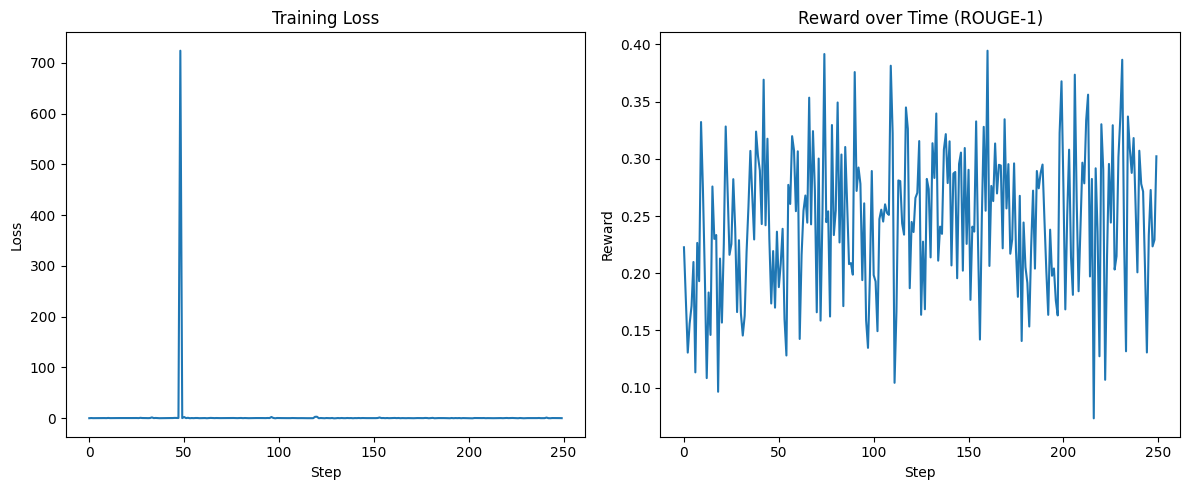

In [13]:
#### YOUR CODE HERE: plot the loss and the rewards of the model training by accessing the trainer logs under grpo_trainer.state.log_history ####
#### YOUR COMMENT HERE: do the plots indicate a trend towards successful training? ####
import matplotlib.pyplot as plt

logs = grpo_trainer.state.log_history

logs = grpo_trainer.state.log_history
losses = [log["loss"] for log in logs if "loss" in log]
rewards = [log["reward"] for log in logs if "reward" in log]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(rewards)
plt.title("Reward over Time (ROUGE-1)")
plt.xlabel("Step")
plt.ylabel("Reward")

plt.tight_layout()
plt.show()


> **QUESTIONS:**
>
> 1. Suppose the plots of rewards below show training metrics for different runs of the summarization model training. Interpret what each of the plots tells us about training success; i.e., did the training run go well on this run? Do we expect to get good summaries? Why? Be concise!
> * *Plot A* is highly unstable with many fluctuations. This might indicate that this training run doesn't converge well or noisy.
> * *Plot B* shows a more stable training phase, however the reward is decreasing. This suggests the reward function was chosen either wrong or not suitable for the task.
> * *Plot C* sharply rises in the beginning and (better) stabilizes later. This run shows that learning is successfull.
> * However, since it is an overall training process, we cannot expect good summaries especially just by leaning on the last training run.
> 2. We have truncated the query articles to maximally 512 tokens. Given that we are using ROUGE with respect to ground truth summaries as a reward, why might this be problematic?
>
>  Because by truncating the examples in the middle of the words or sentences, we lose important context,especially that can be learned from the rest of the text. Since ROUGE compares the ground-truth summaries with the ones we have, it may unfairly penalize our summaries because they are missing the important context expected in our ground_truth.
> 3. GRPO is an algorithm improving over the PPO algorithm (Proximal Policy Optimization). What is they aspect that helps improve over PPO? Explain briefly.
>
> * Unlike PPO, which updates the model based on each reward separately, GRPO uses group-based normalization, comparing a group of outputs together and adjusting rewards based on how good each one is relative to the group. This helps to reduce reward noise and leads to more stable training.
* It also uses KL divergence. This means instead of adding KL penalty in the reward, it regularizes by adding the KL divergence between terined policy and the reference policy. Its loss function consist of two parts with one part being advantage and the other part penalizing deviations from the reference policy through KL divergence. This helps with sample efficiency and better reasoning.
* These aspects make the model very efficient in math problems.
* It uses less computational resources as well, as suggested by the paper.
> 4. In the GRPO paper referenced above, on page 14, you can find the pseudo-algorithm for GRPO. For lines  1--4, 7--8 of the pseudo-code, write down what in our code above instatiates the concepts in the pseudo-code.
* In our reward function, we instantiate 7-8 in this code line : `score = rouge.compute(predictions=[o.strip()], references=[s])["rouge1"]` by taking `num_generations` as group size  . For lines 1-4 , it is done implicitly inside the trainer class , when we give the reward function as a parameter, it calculates(calls) our reward function in each iteration.
> 5. In your own words, explain intuititvely what the role of the *group* in the algorithm is and why it is used. Use max. 3 sentences.
>
> For each question, GRPO samples a group of outputs. It then computes reward for each output instance,afterwards uses the average reward of multiple sampled outputs as the baseline, preventing the use of last token as reward.
> 6.  Name the parameter in the code above that determines the group size.
> num_generations
>

![img](https://github.com/CogSciPrag/Understanding-LLMs-course/blob/main/understanding-llms/homework/data/rewards.png?raw=1)

## Exercise 3: First neural LM (20 points)

Next to reading and understanding package documentations, a key skill for NLP researchers and practitioners is reading and critically assessing NLP literature. The density, but also the style of NLP literature has undergone a significant shift in the recent years with increasing acceleration of progress. Your task in this exercise is to read a paper about one of the first successful neural langauge models, understand its key architectural components and compare how these key components have evolved in modern systems that were discussed in the lecture.

> Specifically, please read the paper by [Bengio et al. (2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and answer the following questions:
>
> * How were words / tokens represented? What is the difference / similarity to modern LLMs?
> * How was the context represented? What is the difference / similarity to modern LLMs?
> * What is the curse of dimensionality? Give a concrete example in the context of language modeling.
> * Which training data was used? What is the difference / similarity to modern LLMs?
> * Which components of the Bengio et al. (2003) model (if any) can be found in modern LMs?
>

Furthermore, your task is to carefully dissect the paper by Bengio et al. (2003) and analyse its structure and style in comparison to another more recent paper:  [Devlin et al. (2019) BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805)

**TASK:**

> For each section of the Bengio et al. (2003) paper, what are key differences between the way it is written, the included contents, to the BERT paper (Devlin et al., 2019)? What are key similarities? Write max. 2 sentences per section.


# **ANSWERS:**

> * **How were words / tokens represented? What is the difference/similarity to modern LLMs?**
>
>  They are represented as a finite set. Each word in the vocabulary are associated with distributed feature vectors, so embeddings. Modern LLMs also use embeddings but not in this way.
> * **How was the context represented? What is the difference / similarity to modern LLMs?**
>
>  Context is represented through mapping an input sequence of feature vectors into a single vector. The size of the sequence is based on the previous n-1 words, in an n-gram model. Modern LLMs don't use fixed window size , they use self-attention mechanism. Therefore they can capture longer dependencies.
> * **What is the curse of dimensionality? Give a concrete example in the context of language modeling.**
>
>  A word sequence on which the model will be tested is likely to be different from all sequences seen during training. If we want to model the joint distribution of 5 consecutive words in a natural language with vocabulary size of 10,000 , there will be potentially 10000^5 -1 = 10^20 -1 free parameters.
> * **Which training data was used? What is the difference / similarity to modern LLMs?**
>
>  Brown corpus consisting of ~1.18M words, with 800K for training, 200K for validation and ~180K for testing.
Another experiment is also done on text from AP News from 1995 and 1996 with a training set consisting of around 14M words. The similarity is that the modern LLMs also use corpuses, but they are very large compared to the ones used in this paper. Nowadays LLMs are trained on even billions of tokens-
> * **Which components of the Bengio et al. (2003) model (if any) can be found in modern LMs?**
>
>  Embeddings, auto-regressive modelling, using softmax before output and they also used Cross-entropy loss and Maximum log likelihood.

# **PAPER COMPARISON**

#### **Abstract:**
----
Bengio et al.(2003) is more abstract and theoretical, making it harder to grasp since it proposes a conceptual solution to a problem. On the other hand, BERT paper is easier to understand, using a simpler language while showing model's empirical performance results from various experiments and benchmarks.

#### **Introduction:**
---
 Bengio et al.(2003)'s introduction is theoretical and research-driven, focusing on foundational concepts without emphasizing NLP applications(since it is an early work). In contrast, the BERT paper is application-focused, addressing specific problems, proposing a concise solution and detailing contributions with practical links.

#### **Related Works:**
---
While both papers use prior work to justify their work's motivation, they differ in many ways because of the posibilities of their time. Bengio et al.(2003)'s related work is more diverse across domains and theoretical depth, since it focuses on a historical perspective on representation learning. In contrast, BERT's has a clear,direct and concise narrative that comparing rich variety of prior works in a narrower area, which is pretraining techniques and NLP architectures.



#### **Model Architecture(2.A Neural Model & 3.Parallel Implementation vs. 3.BERT):**
---
Since Bengio et al.(2003) is one of the first succesful Natural Language Models, it of course builds upon many mathematically-heavy theorems and proposals. Architecture is detailly explained , starting from the theoricial concept "curse of dimensionality" , and explains their solution (embedding) and one by one, context window, linear layers and the whole architecture in detail. It requires good sense of mathematics.In constrast to that, BERT is built upon already existing and largely adopted architecture, therefore it only explains key differences that it has over the other existing Transformer-based models. Thus, it is not mathematically heavy, but requires good knowledge on modern LM architecture.

#### **Experiments**
---
Bengio et al.(2003) conducts two experiments on small datasets named Brown Corpus and AP Newsire, which has limited tasks. BERT paper is, in contrast, heavily relying on empirical results on a rich variety of experiments such as well-known benchmarks(GLUE, SQuAD) and downstream tasks. It has clear comparisions of quantitive results, also uses vast datasets named BooksCorpus and Wikipedia.Additionally, it has ablation studies conducted which is not the case for Bengio et al.(2003).

#### **Future Work**
---
Bengio et al.(2003) has an extensive section that focuses on future work. It promotes on accelerating training and inference using methods like importance sampling and structured linguistic representations, while also addressing out-of-vocabulary words and exploring richer word embeddings. Conversely, BERT paper doesn't have that extensive future work section, it only suggest future improvements in model scaling and domain adaptation.


#### **Results and Discussion**
---
Bengio et al.(2003) doesn't have that extensive quantitive results since it doesn't conduct extensive experiments, rather it uses its theoritical propositions and discusses its limitations.However, BERT, is in a sense promoting the model , focusing on performance gains, task-specific results and improvements, and then point out some limitations such as computing time and hyperparameters.

